# Обучение моделей для кредитного скоринга
Итак, пришло время снова обучить модели для кредитного скоринга. Обучать мы будем две модели
1. Одна будет работать с новыми клиентами банка, о ком еще нет информации в базе данных 
2. Вторая будет работать со старыми клиентами банка, о которых информация в базе данных имеется

Разумеется, первая модель будет хуже второй за счет того, что для первой модели у нас будет меньше данных. Однако мы все равно должны 

Начнем обучение!

Содержание
1. Импорт библиотек
2. Загрузка данных
3. Обучение модели для новых клиентов
    - Предобработка данных
    - Обучение модели
    - Оценка результатов
4. Обучение модели для старых клиентов
    - Предобработка данных
    - Обучение модели
    - Оценка результатов
5. Следующие шаги

## 1. Импорт библиотек

In [1]:
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List
from sklearn.metrics import f1_score, recall_score
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

sns.set_style("darkgrid")

d:\Programming\Projects\CreditScoring\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Загрузка данных

In [8]:
train_data = pd.read_csv("../data/processed/train_dataset.csv", index_col="id")
train_data.head()

,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,default
id,,,,,,,,,,,,,,,,
1.0,27,SCH,32000.0,1.0,1.0,0.0,0.0,-1.917831,0.0,0.0,40.0,2.0,3.0,1.0,4.0,0.0
2.0,26,GRD,50000.0,0.0,0.0,0.0,0.0,-1.153144,2.0,0.0,60.0,2.0,3.0,2.0,1.0,0.0
3.0,35,SCH,20000.0,0.0,0.0,1.0,0.0,-1.732810,0.0,0.0,40.0,1.0,2.0,4.0,3.0,0.0
4.0,35,GRD,80000.0,0.0,0.0,1.0,0.0,-2.552133,2.0,0.0,20.0,2.0,3.0,1.0,3.0,0.0
5.0,24,UGR,27000.0,0.0,0.0,0.0,0.0,-1.914581,1.0,0.0,50.0,2.0,3.0,1.0,2.0,0.0


In [9]:
train_data["education"].unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan, '1'], dtype=object)

In [39]:
def split_data(data) -> Tuple[pd.DataFrame]:
    features = data.drop(["default"], axis=1)
    targets = data["default"]

    return (features, targets)

In [40]:
train_features, train_targets = split_data(train_data)

## 3. Обучение модели для новых клиентов
Информации о новых клиентов нет в базе данных. Если у нас не будет доступов к базам других банков (если новый клиент является клиентом хоть какого-то банка) мы сможем воспользоваться лишь его анкетными данными.

### Предобработка данных

In [41]:
train_features.columns

Index(['age', 'education', 'income', 'has_car', 'car_is_foreign', 'has_work',
       'has_passport', 'bki_score', 'requests_count',
       'rejected_applications_count', 'region_rating', 'home_address_category',
       'work_address_category', 'social_network_analysis_score',
       'first_record_age'],
      dtype='object')

Отберем только те признаки, которые мы можем использовать в анкете

In [ ]:
train_features_model_1 = train_features[[
    'age', 
    'education', 
    'income', 
    'has_car', 
    'has_work',
    'has_passport'
]]

train_features_model_1 = pd.get_dummies(train_features_model_1, columns=["education"], dtype=int)

train_features_model_1.head()

,age,income,has_car,has_work,has_passport,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
id,,,,,,,,,,
1,27,32000,1,0,0,0,0,0,1,0
2,26,50000,0,0,0,0,1,0,0,0
3,35,20000,0,1,0,0,0,0,1,0
4,35,80000,0,1,0,0,1,0,0,0
5,24,27000,0,0,0,0,0,0,0,1


In [ ]:
train_features_model_1.shape, train_targets.shape

((180816, 10), (180816,))

Это максимальный приемлемый набор характеристик клиента, которые он впринципе может ввести. Признаков немного, а значит конверсия будет на высоте.

Разобьем получившуюся выборку на тренировочную, валидационную и тестовую

**Стратифицированное разбиение (stratify):**
- Параметр `stratify` в `train_test_split` сохраняет пропорции классов в обучающей и тестовой выборках
- Это особенно важно при работе с несбалансированными данными
- Без стратификации может получиться, что в тестовой выборке будет слишком мало примеров минорного класса
- Использование: `stratify=y` (передаем целевой признак)

In [44]:
TEST_SPLIT=.2
VALIDATION_SPLIT=.1

# Стратифицированное разбиение: сохраняет пропорции классов в обучающей и тестовой выборках
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    train_features_model_1, 
    train_targets, 
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=train_targets  # стратификация по целевому признаку
)

# Также применяем стратификацию при разбиении на train и validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_validation, 
    y_train_validation, 
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train_validation  # стратификация по целевому признаку
)

# Проверим распределение классов в каждой выборке
print("Распределение классов в обучающей выборке:")
print(f"  Класс 0: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  Класс 1: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")

print("\nРаспределение классов в валидационной выборке:")
print(f"  Класс 0: {sum(y_valid == 0)} ({sum(y_valid == 0)/len(y_valid)*100:.2f}%)")
print(f"  Класс 1: {sum(y_valid == 1)} ({sum(y_valid == 1)/len(y_valid)*100:.2f}%)")

print("\nРаспределение классов в тестовой выборке:")
print(f"  Класс 0: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  Класс 1: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.2f}%)")

print(f"\nРазмеры выборок: train={X_train.shape}, valid={X_valid.shape}, test={X_test.shape}") 

Распределение классов в обучающей выборке:
  Класс 0: 115186 (88.48%)
  Класс 1: 15000 (11.52%)

Распределение классов в валидационной выборке:
  Класс 0: 12799 (88.48%)
  Класс 1: 1667 (11.52%)

Распределение классов в тестовой выборке:
  Класс 0: 31997 (88.48%)
  Класс 1: 4167 (11.52%)

Размеры выборок: train=(130186, 10), valid=(14466, 10), test=(36164, 10)


In [45]:
def smote_data(
    features: pd.DataFrame,
    targets: pd.DataFrame,
    indices: list[int],
    seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    # Проверим распределение классов до балансировки
    print("Распределение классов ДО балансировки:")
    print(f"Класс 0 (не дефолт): {sum(targets == 0)}")
    print(f"Класс 1 (дефолт): {sum(targets == 1)}")
    print(f"Доля дефолтов: {sum(targets == 1) / len(targets) * 100:.2f}%")

    # Определим индексы категориальных признаков
    # Порядок: 'age', 'education', 'income', 'has_car',  'has_work', 'has_passport'
    # Индексы категориальных: education(1), has_car(3), has_work(4), has_passport(5)
    #indices = [i for i in range(2, 10)]

    # Применим SMOTENC (SMOTE с категориальными признаками)
    smote_nc = SMOTENC(categorical_features=indices, random_state=seed)
    features, targets = smote_nc.fit_resample(features, targets)

    print("\nРаспределение классов ПОСЛЕ SMOTE:")
    print(f"Класс 0 (не дефолт): {sum(targets == 0)}")
    print(f"Класс 1 (дефолт): {sum(targets == 1)}")
    print(f"Доля дефолтов: {sum(targets == 1) / len(targets) * 100:.2f}%")

    return features, targets

In [46]:
X_train, y_train = smote_data(X_train, y_train, indices=[i for i in range(2, 10)])

Распределение классов ДО балансировки:
Класс 0 (не дефолт): 115186
Класс 1 (дефолт): 15000
Доля дефолтов: 11.52%

Распределение классов ПОСЛЕ SMOTE:
Класс 0 (не дефолт): 115186
Класс 1 (дефолт): 115186
Доля дефолтов: 50.00%


### Обучение модели
В данном сценарии применим модель `CatBoost` (модель градиентного бустинга от Яндекса), которая хорошо справляется с категориальными признаками. Для оптимизации модели воспользуемся библиотекой `Optuna`

In [47]:
categorical_features = X_train.columns[2:].to_list() 

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "eval_metric": "F1",
        "loss_function": "Logloss",
        "verbose": False,
        "class_weights": [1, sum(y_train==0)/sum(y_train==1)]
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

    preds = model.predict(X_valid)
    return recall_score(y_valid, preds)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)

# Финальная модель
best_model = CatBoostClassifier(**study.best_params)
best_model.fit(train_pool, eval_set=valid_pool)

# Сохраним модель 
best_model.save_model("../artifacts/models/best_catboost_model_new_client_v0.cbm")

[I 2025-12-19 20:57:05,332] A new study created in memory with name: no-name-11261c1e-21c7-4315-9740-00720dfcb9d4
[I 2025-12-19 20:57:06,513] Trial 0 finished with value: 0.6124775044991002 and parameters: {'iterations': 371, 'depth': 8, 'learning_rate': 0.011842394011566061, 'l2_leaf_reg': 5.764557889889746, 'subsample': 0.8666564287627654, 'random_strength': 4.434541841781406, 'border_count': 219}. Best is trial 0 with value: 0.6124775044991002.
[I 2025-12-19 20:57:09,239] Trial 1 finished with value: 0.6424715056988602 and parameters: {'iterations': 862, 'depth': 6, 'learning_rate': 0.2417422634648855, 'l2_leaf_reg': 5.191083157311701, 'subsample': 0.8208245093463773, 'random_strength': 7.875333515154786, 'border_count': 35}. Best is trial 1 with value: 0.6424715056988602.
[I 2025-12-19 20:57:13,833] Trial 2 finished with value: 0.6094781043791242 and parameters: {'iterations': 498, 'depth': 10, 'learning_rate': 0.25631263983242936, 'l2_leaf_reg': 6.808768873629149, 'subsample': 0.8

Лучшие параметры: {'iterations': 585, 'depth': 4, 'learning_rate': 0.01964496378591967, 'l2_leaf_reg': 7.230537959341048, 'subsample': 0.7285902352175431, 'random_strength': 7.8620600277494175, 'border_count': 235}
0:	learn: 0.6926009	test: 0.6925648	best: 0.6925648 (0)	total: 13.5ms	remaining: 7.87s
1:	learn: 0.6920491	test: 0.6920173	best: 0.6920173 (1)	total: 25ms	remaining: 7.29s
2:	learn: 0.6917195	test: 0.6917199	best: 0.6917199 (2)	total: 34.7ms	remaining: 6.73s
3:	learn: 0.6912036	test: 0.6912306	best: 0.6912306 (3)	total: 46.8ms	remaining: 6.79s
4:	learn: 0.6907252	test: 0.6907767	best: 0.6907767 (4)	total: 60.5ms	remaining: 7.02s
5:	learn: 0.6902633	test: 0.6903015	best: 0.6903015 (5)	total: 70.8ms	remaining: 6.83s
6:	learn: 0.6897528	test: 0.6897689	best: 0.6897689 (6)	total: 81.5ms	remaining: 6.73s
7:	learn: 0.6892326	test: 0.6893028	best: 0.6893028 (7)	total: 95.1ms	remaining: 6.86s
8:	learn: 0.6886982	test: 0.6887834	best: 0.6887834 (8)	total: 104ms	remaining: 6.69s
9:	le

In [48]:
def accuracy(
    targets: pd.DataFrame | pd.Series | List, 
    predictions: pd.DataFrame | pd.Series | List
) -> float:
    return sum(predictions == targets) / len(predictions)

In [49]:
model = CatBoostClassifier()
model.load_model("../artifacts/models/best_catboost_model_new_client_v0.cbm")

threshold = .5

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)
acc = accuracy(y_test, y_pred)
print(f"Модель достигла accuracy равной {acc * 100:.1f}%")

Модель достигла accuracy равной 54.5%


### Оценка результатов
Построим матрицу ошибок

In [50]:
def draw_confusion_matrix(
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int],
    classes: pd.Series | List
) -> None:
    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.grid(False)
    plt.show()

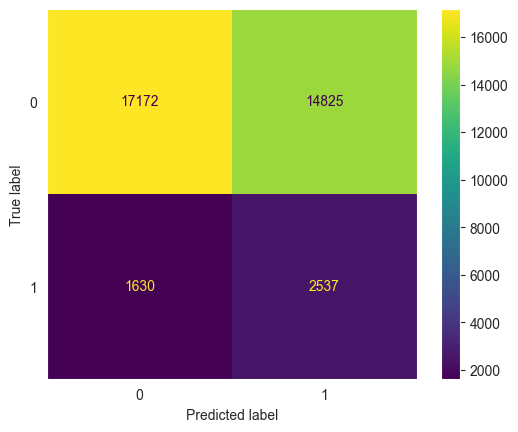

In [51]:
draw_confusion_matrix(targets=y_test, predictions=y_pred, classes=model.classes_)

Рассчитаем AUROC

In [52]:
def plot_roc( 
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int]
):
    roc_auc = roc_auc_score(targets, predictions)

    # Для построения кривой ROC
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

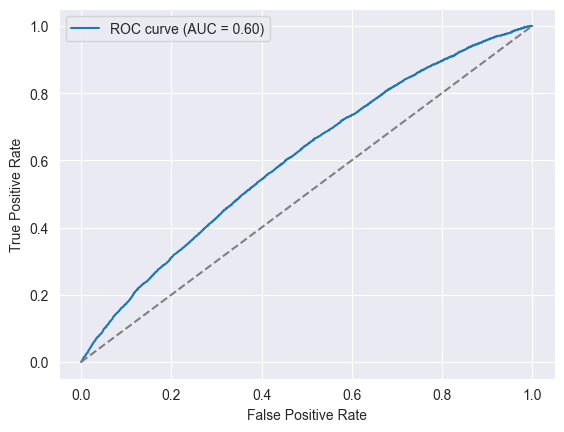

In [53]:
plot_roc(targets=y_test, predictions=y_pred_proba)

Получили почти такую же по качеству модель, как и в первой версии системы

## 4. Обучение модели для старых клиентов
### Предобработка данных
Для старых клиентов мы будем использовать все имеющиеся признаки

In [62]:
train_features_model_2 = train_features.copy()
train_features_model_2 = pd.get_dummies(train_features_model_2, columns=["education"], dtype=int)
train_features_model_2.head()

,age,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
id,,,,,,,,,,,,,,,,,,,
1,27,32000,1,1,0,0,-1.917831,0,0,40,2,3,1,4,0,0,0,1,0
2,26,50000,0,0,0,0,-1.153144,2,0,60,2,3,2,1,0,1,0,0,0
3,35,20000,0,0,1,0,-1.732810,0,0,40,1,2,4,3,0,0,0,1,0
4,35,80000,0,0,1,0,-2.552133,2,0,20,2,3,1,3,0,1,0,0,0
5,24,27000,0,0,0,0,-1.914581,1,0,50,2,3,1,2,0,0,0,0,1


In [63]:
TEST_SPLIT=.2
VALIDATION_SPLIT=.1

# Стратифицированное разбиение: сохраняет пропорции классов в обучающей и тестовой выборках
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    train_features_model_2, 
    train_targets, 
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=train_targets  # стратификация по целевому признаку
)

# Также применяем стратификацию при разбиении на train и validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_validation, 
    y_train_validation, 
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train_validation  # стратификация по целевому признаку
)

# Проверим распределение классов в каждой выборке
print("Распределение классов в обучающей выборке:")
print(f"  Класс 0: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  Класс 1: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")

print("\nРаспределение классов в валидационной выборке:")
print(f"  Класс 0: {sum(y_valid == 0)} ({sum(y_valid == 0)/len(y_valid)*100:.2f}%)")
print(f"  Класс 1: {sum(y_valid == 1)} ({sum(y_valid == 1)/len(y_valid)*100:.2f}%)")

print("\nРаспределение классов в тестовой выборке:")
print(f"  Класс 0: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  Класс 1: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.2f}%)")

print(f"\nРазмеры выборок: train={X_train.shape}, valid={X_valid.shape}, test={X_test.shape}") 

Распределение классов в обучающей выборке:
  Класс 0: 115186 (88.48%)
  Класс 1: 15000 (11.52%)

Распределение классов в валидационной выборке:
  Класс 0: 12799 (88.48%)
  Класс 1: 1667 (11.52%)

Распределение классов в тестовой выборке:
  Класс 0: 31997 (88.48%)
  Класс 1: 4167 (11.52%)

Размеры выборок: train=(130186, 19), valid=(14466, 19), test=(36164, 19)


In [64]:
train_features_model_2.head()

,age,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
id,,,,,,,,,,,,,,,,,,,
1,27,32000,1,1,0,0,-1.917831,0,0,40,2,3,1,4,0,0,0,1,0
2,26,50000,0,0,0,0,-1.153144,2,0,60,2,3,2,1,0,1,0,0,0
3,35,20000,0,0,1,0,-1.732810,0,0,40,1,2,4,3,0,0,0,1,0
4,35,80000,0,0,1,0,-2.552133,2,0,20,2,3,1,3,0,1,0,0,0
5,24,27000,0,0,0,0,-1.914581,1,0,50,2,3,1,2,0,0,0,0,1


In [65]:
X_train, y_train = smote_data(X_train, y_train, indices=[*range(2, 6), *range(10, 19)])

Распределение классов ДО балансировки:
Класс 0 (не дефолт): 115186
Класс 1 (дефолт): 15000
Доля дефолтов: 11.52%

Распределение классов ПОСЛЕ SMOTE:
Класс 0 (не дефолт): 115186
Класс 1 (дефолт): 115186
Доля дефолтов: 50.00%


### Обучение модели
Как и для новых клиентов, применим алгоритм CatBoost

In [66]:
from sklearn.metrics import recall_score
categorical_features = [*X_train.columns[2:6], *X_train.columns[10:19]]

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "eval_metric": "F1",
        "loss_function": "Logloss",
        "verbose": False,
        "class_weights": [1, sum(y_train==0)/sum(y_train==1)]
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

    preds = model.predict(X_valid)
    return recall_score(y_valid, preds)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)

# Финальная модель
best_model = CatBoostClassifier(**study.best_params)
best_model.fit(train_pool, eval_set=valid_pool)

# Сохраним модель 
best_model.save_model("../artifacts/models/best_catboost_model_old_client_v0.cbm")

[I 2025-12-19 21:18:55,863] A new study created in memory with name: no-name-ecb7a281-5dee-4eca-93a8-aecd24ce132c
[I 2025-12-19 21:19:03,240] Trial 0 finished with value: 0.5614877024595081 and parameters: {'iterations': 869, 'depth': 5, 'learning_rate': 0.21928839375258039, 'l2_leaf_reg': 2.4485297016140612, 'subsample': 0.508048380393997, 'random_strength': 8.653857643799585, 'border_count': 127}. Best is trial 0 with value: 0.5614877024595081.
[I 2025-12-19 21:19:10,337] Trial 1 finished with value: 0.5680863827234554 and parameters: {'iterations': 469, 'depth': 4, 'learning_rate': 0.23798253462847543, 'l2_leaf_reg': 3.824325956689606, 'subsample': 0.7240821897527764, 'random_strength': 8.631141509402195, 'border_count': 94}. Best is trial 1 with value: 0.5680863827234554.
[I 2025-12-19 21:19:24,005] Trial 2 finished with value: 0.5506898620275945 and parameters: {'iterations': 870, 'depth': 9, 'learning_rate': 0.11306080658152791, 'l2_leaf_reg': 9.55347927850276, 'subsample': 0.894

Лучшие параметры: {'iterations': 518, 'depth': 4, 'learning_rate': 0.04111900736413569, 'l2_leaf_reg': 4.1028993042828015, 'subsample': 0.7733367690504143, 'random_strength': 8.924129468109863, 'border_count': 182}
0:	learn: 0.6877812	test: 0.6878073	best: 0.6878073 (0)	total: 77.4ms	remaining: 40s
1:	learn: 0.6817295	test: 0.6817411	best: 0.6817411 (1)	total: 146ms	remaining: 37.6s
2:	learn: 0.6762291	test: 0.6762978	best: 0.6762978 (2)	total: 214ms	remaining: 36.8s
3:	learn: 0.6704781	test: 0.6705448	best: 0.6705448 (3)	total: 282ms	remaining: 36.2s
4:	learn: 0.6641070	test: 0.6644476	best: 0.6644476 (4)	total: 353ms	remaining: 36.2s
5:	learn: 0.6582344	test: 0.6588941	best: 0.6588941 (5)	total: 421ms	remaining: 35.9s
6:	learn: 0.6533445	test: 0.6544647	best: 0.6544647 (6)	total: 487ms	remaining: 35.5s
7:	learn: 0.6497302	test: 0.6510316	best: 0.6510316 (7)	total: 554ms	remaining: 35.3s
8:	learn: 0.6455192	test: 0.6467164	best: 0.6467164 (8)	total: 622ms	remaining: 35.2s
9:	learn: 0.

In [67]:
model = CatBoostClassifier()
model.load_model("../artifacts/models/best_catboost_model_old_client_v0.cbm")

threshold = .35

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)
acc = accuracy(y_test, y_pred)
print(f"Модель достигла accuracy равной {acc * 100:.1f}%")

Модель достигла accuracy равной 54.8%


### Оценка результатов
Взглянем на матрицу ошибок

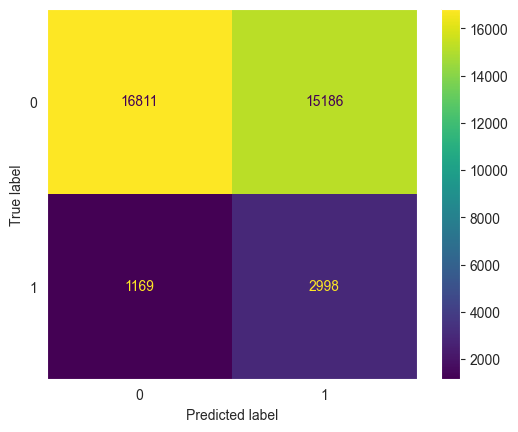

In [68]:
draw_confusion_matrix(targets=y_test, predictions=y_pred, classes=model.classes_)

Оценим AUROC полученного решения

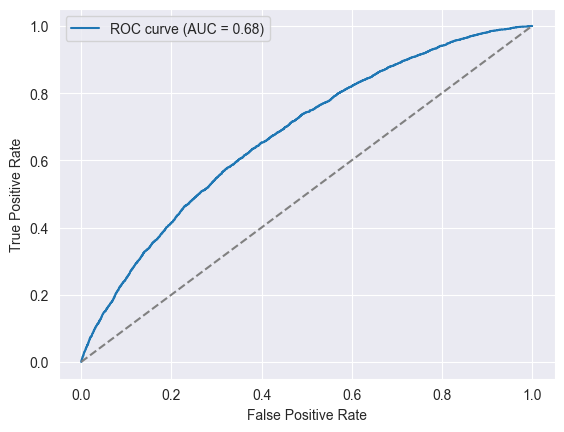

In [69]:
plot_roc(targets=y_test, predictions=y_pred_proba)

Мы получили модель лучшего качества, чем для новых клиентов

## 5. Следующие шаги
Итак, мы построили две модели для классификации клиентов. Хоть мы и получили модели с достойными относительно оригинального [соревнования](https://www.kaggle.com/competitions/fintech-credit-scoring) результатами, было бы неплохо поэкспериментировать и с другими моделями классического машинного обучения, например другими линейными моделями, ансамблями или вовсе попробовать применить нейронные сети.

Поэтому в директории `/source` будет разработан **pipeline обучения и мониторинга** различных видов моделей и выделение лучшей из них

Далее, отобрав лучший вариант, мы перейдем к развертыванию моделей в онлайне. Для этого:
- Сохраним данные старых клиентов в базе данных (с PostgreSQL в качестве СУБД)
- Напишем сервер-инференс для наших моделей
- Напишем сервер, компонующий работу сервера-инференса и базы данных
- Обновим клиентскую часть
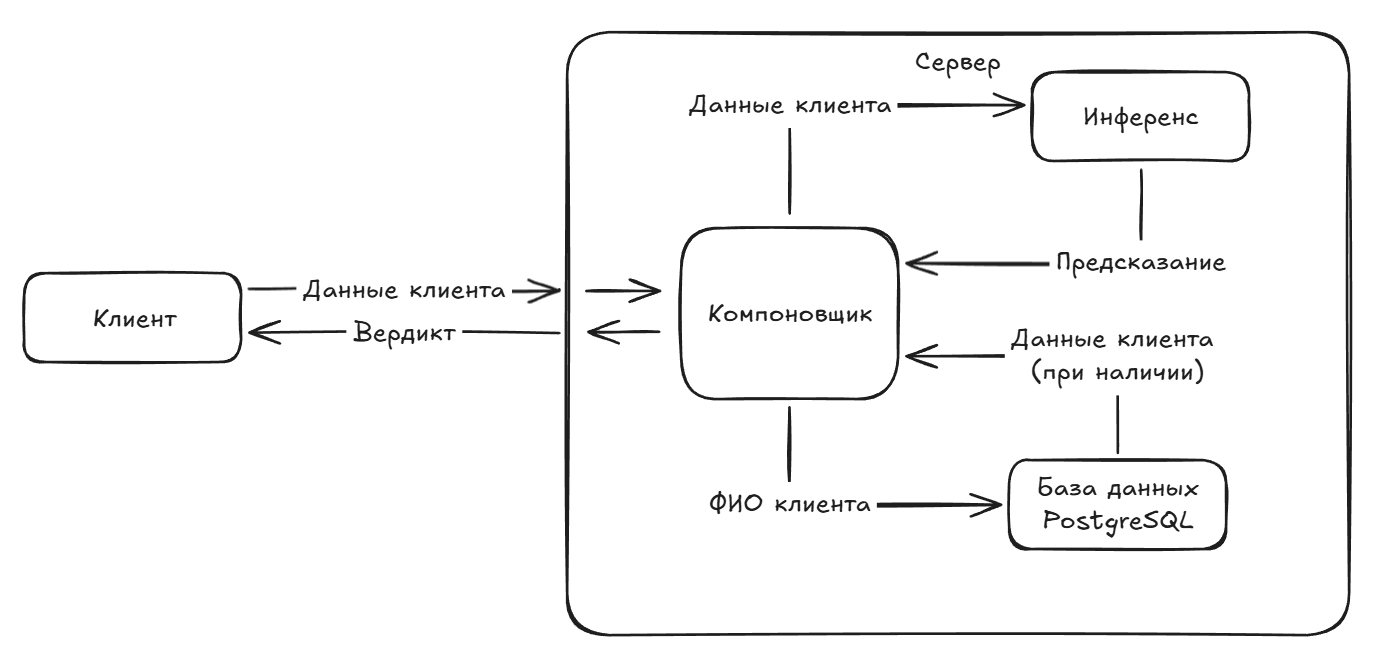